In [54]:
!pip install -q -U transformers num2words

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 15.1 MB/s eta 0:00:00


# Library code, modified

MQT Q-Former from https://github.com/gordonhu608/MQT-LLaVA

In [11]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.init import trunc_normal_
import math
from functools import partial
import numpy as np
import random

def get_matry_n(num_visual_tokens):
    if num_visual_tokens == 'first_stage':
        return 729
    elif num_visual_tokens == 'second_stage':
        matry_list = range(1, 730, 4)
        return random.choice(matry_list)

    try:
        num_visual_tokens = int(num_visual_tokens)
        if 1 <= num_visual_tokens <= 729:
            return num_visual_tokens
    except (ValueError, TypeError):
        print('The num_visual_tokens is should be an integer between 1 and 729')

    raise ValueError(f"Invalid input: {num_visual_tokens}")

def get_abs_pos(abs_pos, tgt_size):
    # abs_pos: L, C
    # tgt_size: (H, W)
    # return: M, C
    src_size = int(math.sqrt(abs_pos.size(0)))
    # tgt_size = int(math.sqrt(tgt_size))
    dtype = abs_pos.dtype
    return F.interpolate(
        abs_pos.float().reshape(1, src_size, src_size, -1).permute(0, 3, 1, 2),
        size=(tgt_size[0], tgt_size[1]),
        mode="bicubic",
        align_corners=False,
    ).permute(0, 2, 3, 1).flatten(0, 2).to(dtype=dtype)


# https://github.com/facebookresearch/mae/blob/efb2a8062c206524e35e47d04501ed4f544c0ae8/util/pos_embed.py#L20
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])


    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000 ** omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


class Resampler(nn.Module):
    """
    A 2D perceiver-resampler network with one cross attention layers by
        (grid_size**2) learnable queries and 2d sincos pos_emb
    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6)
    ):
        super().__init__()
        self.num_queries = grid_size ** 2
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        self.pos_embed = nn.Parameter(
            torch.from_numpy(get_2d_sincos_pos_embed(kv_dim, grid_size)).half()
        ).requires_grad_(False)

        self.query = nn.Parameter(torch.zeros(self.num_queries, kv_dim)).to(torch.float32)
        trunc_normal_(self.query, std=.02)

        self.attn = nn.MultiheadAttention(kv_dim, num_heads).to(device = "cuda:0", dtype=torch.float32)

        self.ln_q = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.float32)
        self.ln_k = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.float32)
        self.ln_v = norm_layer(kv_dim).to(device = "cuda:0", dtype=torch.float32)

        # self.ln_post = norm_layer(kv_dim)
        self.proj = nn.Parameter((embed_dim ** -0.5) * torch.randn(kv_dim, embed_dim)).to(device="cuda:0")

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, num_visual_tokens=256, tgt_size=(24,24), attn_mask=None):
        pos_embed = get_abs_pos(self.pos_embed, tgt_size)

        x = x.permute(1, 0, 2)  # x: (seq_len, batch_size, dim)
        B = x.shape[1]  # true batch size


        matry_n = get_matry_n(num_visual_tokens)
        q = self.query[:matry_n]  # (matry_n, dim)
        q = self._repeat(q, B)    # (matry_n, B, dim)

        k = self._repeat(pos_embed, B).to(device = "cuda:0", dtype=torch.float32)
        v = x
        q= q.to(device = "cuda:0")
        # self.pos_embed = self.pos_embed.to(device = "cuda:0")

        q = self.ln_q(q + self.pos_embed[:matry_n].unsqueeze(1).to(device = "cuda:0")).to(device = x.device ,dtype=torch.float32)
        k = self.ln_k(k).to(device = x.device ,dtype=torch.float32)
        v = self.ln_v(v).to(device = x.device ,dtype=torch.float32)

        out = self.attn(q, k, v, attn_mask=attn_mask)[0]  # (matry_n, B, dim)


        x = out.permute(1, 0, 2)

        x = x @ self.proj
        # print(x.shape)
        return x

    def _repeat(self, query, N: int):
        return query.unsqueeze(1).repeat(1, N, 1)

In [12]:
class MultiResampler(nn.Module):
    """
    experimental multi-resampler

    Args:
        num_resamplers:int = number of resamplers(qformers)

    Outputs:
        A tensor with the shape of (grid_size**2, embed_dim)
    """

    def __init__(
            self,
            grid_size,
            embed_dim,
            num_heads,
            num_resamplers,
            kv_dim=None,
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__()
        self.resamplers = [Resampler(grid_size, embed_dim, num_heads, kv_dim, norm_layer) for _ in range(num_resamplers)]

    def _init_weights(self, m):
        for i in  range(len(self.resamplers)):
            self.resamplers[i]._init_weights(m)

    def forward(self, x, num_visual_tokens=256, tgt_size=(27,27), attn_mask=None):
        # raise NotImplementedError()
        # x should be a list
        assert len(x) == len(self.resamplers)

        num_vt_each = num_visual_tokens//len(self.resamplers)
        outs = []
        for i in range(len(self.resamplers)):
            outs.append(self.resamplers[i].forward(x[i], num_vt_each, tgt_size))
        concat = torch.cat(outs, dim=1)
        return concat

# Load Model

In [1]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import num2words

model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.03G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [ ]:
model.config

SmolVLMConfig {
  "architectures": [
    "SmolVLMForConditionalGeneration"
  ],
  "image_token_id": 49190,
  "model_type": "smolvlm",
  "pad_token_id": 128002,
  "scale_factor": 3,
  "text_config": {
    "_flash_attn_2_enabled": true,
    "_name_or_path": "None",
    "architectures": [
      "VLlama3ForCausalLM"
    ],
    "attention_bias": false,
    "attention_dropout": 0.0,
    "head_dim": 64,
    "hidden_act": "silu",
    "hidden_size": 2048,
    "initializer_range": 0.02,
    "intermediate_size": 8192,
    "max_position_embeddings": 8192,
    "mlp_bias": false,
    "model_type": "llama",
    "neftune_noise_alpha": 0.0,
    "num_attention_heads": 32,
    "num_hidden_layers": 24,
    "num_key_value_heads": 32,
    "pad_token_id": 2,
    "perceiver_config": {
      "_attn_implementation_autoset": false,
      "_name_or_path": "",
      "add_cross_attention": false,
      "architectures": null,
      "attention_dropout": 0.0,
      "bad_words_ids": null,
      "begin_suppress_tokens":

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

2246784880

In [ ]:
sum(p.numel() for p in model.model.vision_model.parameters() if p.requires_grad)

412987248

In [ ]:
# conversation = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image", "url": "sample.png"},
#             {"type": "text", "text": "Describe this image."}
#         ]
#     }
# ]

# inputs = processor.apply_chat_template(
#     conversation,
#     add_generation_prompt=True,
#     tokenize=True,
#     return_dict=True,
#     return_tensors="pt"
# ).to(model.device, dtype=torch.bfloat16)

# output_ids = model.generate(**inputs, max_new_tokens=128)
# generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)

In [ ]:
generated_texts

# Q-Former

In [7]:
qformer_config = {
    "grid_size": 27,
    "embed_dim": 1152,
    "num_heads": 16,
    "num_resamplers": 4,
    "kv_dim": 1152
}

In [28]:
import torch
import torch.nn as nn
from transformers.modeling_outputs import BaseModelOutput
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

class MultiCropVisionEncoder(nn.Module):
    def __init__(self, qformer_config):
        super().__init__()
        self.num_resamplers = qformer_config["num_resamplers"]
        self.embed_dim = qformer_config["embed_dim"]
        self.grid_size = qformer_config["grid_size"]

        self.patch_embed = nn.Conv2d(3, qformer_config["embed_dim"], kernel_size=14, stride=14).to(torch.float32)
        self.multi_resampler = MultiResampler(
            grid_size=qformer_config["grid_size"],
            embed_dim=qformer_config["embed_dim"],
            num_heads=qformer_config["num_heads"],
            num_resamplers=qformer_config["num_resamplers"],
            kv_dim=qformer_config["kv_dim"],
            norm_layer=partial(nn.LayerNorm, eps=1e-6),
        )

    def forward(self, pixel_values, patch_attention_mask=None):
        pixel_values = pixel_values.to(torch.float32)
        b4, c, h, w = pixel_values.shape
        assert b4 % self.num_resamplers == 0, "Batch size must be divisible by number of resamplers"
        batch_size = b4 // self.num_resamplers

        image = np.transpose(pixel_values[0].to(dtype=torch.float32).cpu(), (1, 2, 0))
        plt.imshow(image)
        plt.show()

        x = self.patch_embed(pixel_values)
        x = x.flatten(2).transpose(1, 2)
        x = x.view(batch_size, self.num_resamplers, self.grid_size**2, self.embed_dim)
        x_list = list(x.unbind(dim=1))

        out = self.multi_resampler(x_list, num_visual_tokens=self.grid_size**2*self.num_resamplers)

        # print(out.shape)
        out = out.view(batch_size * self.num_resamplers, self.grid_size**2, self.embed_dim).to(
            device=pixel_values.device,
            dtype=torch.bfloat16
        )
        print(out.shape)
        return BaseModelOutput(last_hidden_state=out)

In [29]:
test_vm = MultiCropVisionEncoder(qformer_config)
test_vm = test_vm.to(device= "cuda:0", dtype=torch.float32)

In [41]:
sum(p.numel() for p in test_vm.parameters() if p.requires_grad)

678528

# Integration

## loading the test image

In [23]:
from PIL import Image
image = Image.open("sample.png")

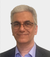

In [24]:
base_width = 50
w_percent = (base_width / float(image.size[0]))
h_size = int((float(image.size[1]) * float(w_percent)))
resized_image = image.resize((base_width, h_size), Image.Resampling.LANCZOS)

display(resized_image)

## modifying model config to support new vision model

In [19]:
qformer_config

{'grid_size': 27,
 'embed_dim': 1152,
 'num_heads': 16,
 'num_resamplers': 4,
 'kv_dim': 1152}

In [20]:
old_config = model.config.vision_config

In [ ]:
old_config

SmolVLMVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_size": 1152,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4304,
  "layer_norm_eps": 1e-06,
  "max_image_size": {
    "longest_edge": 384
  },
  "model_type": "smolvlm_vision",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 27,
  "patch_size": 14,
  "size": {
    "longest_edge": 1920
  },
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.55.0",
  "use_base_siglip": false
}

In [21]:
class Config:
    def __init__(self, dictionary, old_config):
        for key, value in old_config.items():
            setattr(self, key, value)
        for key, value in dictionary.items():
            setattr(self, key, value)

qformer_config_obj = Config(qformer_config, old_config.get_config_dict(model_path)[0]["vision_config"])

## swapping vision model

the commented codes below are used to check the inner dimensions of the original and new model. not removed in case further debugging is needed.

In [ ]:
old_vision_model = model.model.vision_model

In [ ]:
model.model.vision_model = None

In [58]:
model.model.vision_model = MultiCropVisionEncoder(qformer_config).to("cuda:0")
model.config.vision_config = qformer_config_obj

In [59]:
sum(p.numel() for p in model.model.vision_model.parameters() if p.requires_grad)

678528

In [ ]:
# dummy = torch.randn(1, 3, 384,384).to(device="cpu", dtype=torch.bfloat16)
# old_vision_model = old_vision_model.to("cpu")
# old_vision_model(dummy).last_hidden_state.shape

torch.Size([1, 729, 1152])

In [44]:
processor.image_processor.max_image_size["longest_edge"]= 384

In [26]:
processor.image_processor.do_image_splitting=False
processor.image_processor.do_resize=True

## testing new model inference for errors

In [ ]:
model.device

device(type='cuda', index=0)

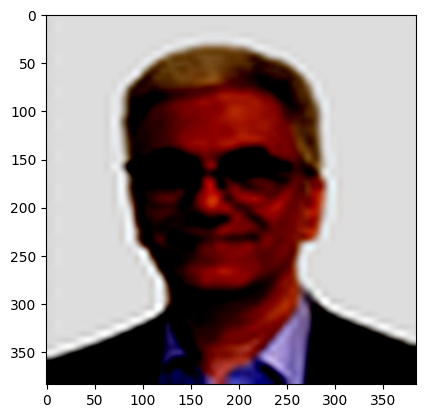

torch.Size([4, 729, 1152])


['User:describe this image.\nAssistant:']

In [60]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            {"type": "text", "text": "describe this image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=32)
generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
generated_texts

In [48]:
model.model.vision_model

MultiCropVisionEncoder(
  (patch_embed): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14))
  (multi_resampler): MultiResampler()
)

---


In [ ]:
# Colab setup
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'LLM-Project')
os.chdir(GOOGLE_DRIVE_PATH)

In [ ]:
! pip -q install bitsandbytes

# DriveLM

In [ ]:
import os
from PIL import Image

nuscenes_path = 'DriveLM/data/nuscenes/samples/'

nuscenes = {}

for folder in os.listdir(nuscenes_path):
    folder_path = os.path.join(nuscenes_path, folder)
    if os.path.isdir(folder_path):
        nuscenes[folder] = {}
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            nuscenes[folder][img_name] = Image.open(img_path)


In [ ]:
import json
from datasets import Dataset


class DriveLM:
    def __init__(self, json_path="DriveLM/data/QA_dataset_nus/v1_0_train_nus.json"):

        with open(json_path, 'r') as f:
            data = json.load(f)

        examples = []
        for scene_token, scene_data in data.items():
            scene_desc = scene_data.get('scene_description')
            for frame_token, frame_data in scene_data['key_frames'].items():
                image_paths = frame_data.get('image_paths', {})
                for task, qa_list in frame_data['QA'].items():
                    for qa in qa_list:
                        example = {
                            "scene_token": scene_token,
                            "frame_token": frame_token,
                            "scene_description": scene_desc,
                            "task": task,
                            "question": qa.get("Q"),
                            "answer": qa.get("A"),
                            "context": qa.get("C"),
                            "image_paths": image_paths,
                        }
                        examples.append(example)

        self.hf_dataset = Dataset.from_list(examples)

    def filter(self, function):
        self.hf_dataset = self.hf_dataset.filter(function)


    def __getitem__(self, idx):
      keys = ['scene_description', 'question', 'answer']
      sample = {key: self.hf_dataset[idx][key] for key in keys}

      sample['images'] = {}
      for image_type, image_path in self.hf_dataset[idx]['image_paths'].items():
          image_name = image_path.split('/')[-1]
          sample['images'][image_type] = nuscenes[image_type][image_name]
      return sample

    def __len__(self):
        return len(self.hf_dataset)


dataset = DriveLM()

In [ ]:
import re


def contains_object(text):
    return re.search(r'<*>',text) != None

dataset.filter(lambda example: not contains_object(example['question']) and not contains_object(example['answer']))

len(dataset)

In [ ]:
from PIL import Image

def concatenate_images(imgs):
    total_width = imgs[0].width * len(imgs)
    img_combined = Image.new('RGB', (total_width, imgs[0].height))

    x_offset = 0
    for img in imgs:
        img_combined.paste(img, (x_offset, 0))
        x_offset += img.width

    return img_combined

# Fine-tune

In [ ]:
from torch.utils.data import Dataset

class VLMQADataset(Dataset):
    def __init__(self, dataset: DriveLM):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        front_cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT']
        back_cameras = ['CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
        user_msg = []
        # cameras = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
        # for camera in cameras:
        #     user_msg.extend([
        #         {"type": "text", "text": camera},
        #         {"type": "image", "image": item["images"][camera]}
        #     ])

        front = concatenate_images([item["images"][camera] for camera in front_cameras])
        back = concatenate_images([item["images"][camera] for camera in back_cameras])
        user_msg.extend([
            {"type": "text", "text": "The following image is a horizontal concatenation of three FRONT vehicle camera views: font left, front, and front right:"},
            {"type": "image", "image": front},
            {"type": "text", "text": "The following image is a horizontal concatenation of three BACK vehicle camera views: back left, back, and back right:"},
            {"type": "image", "image": back}
        ])

        user_msg.append({"type": "text", "text":item["question"]})

        conversation = [
            {
                "role": "user",
                "content": user_msg,
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": item["answer"]},
                ],
            }
        ]

        target = [
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": item["answer"]},
                ],
            }
        ]

        target_inputs = processor.apply_chat_template(
            target,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(torch.float16)

        inputs = processor.apply_chat_template(
            conversation,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        ).to(torch.float16)

        labels = inputs['input_ids'].clone()
        # labels[:num_image_tokens] = -100  # Mask out image tokens

        # Mask all tokens before the assistant's answer
        start_idx = inputs['input_ids'].shape[1] - target_inputs['input_ids'].shape[1]
        labels[:, :start_idx] = -100

        inputs['labels'] = labels

        return inputs


In [ ]:
data = VLMQADataset(dataset)

In [ ]:
from peft import prepare_model_for_kbit_training

model2 = prepare_model_for_kbit_training(model)
del model

model2.gradient_checkpointing_enable()
model2.enable_input_require_grads()

In [ ]:
from peft import LoraConfig, get_peft_model
from transformers import Trainer, TrainingArguments

peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules="all-linear",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model2, peft_config)

In [ ]:
peft_model.print_trainable_parameters()

In [ ]:
import torch
import gc


# del model2, processor, peft_model
torch.cuda.empty_cache()
gc.collect()


In [ ]:
from transformers import Trainer, TrainingArguments

train_dataset = VLMQADataset(dataset)

training_args = TrainingArguments(
    output_dir="./checkpoints",
    per_device_train_batch_size=1,
    num_train_epochs=1,
    learning_rate=2e-5,
    logging_steps=1,
    save_steps=200,
    bf16=True,
    report_to="none",
    label_names=["labels"],
    gradient_checkpointing=True,
)


def pad_labels(labels):
    pad_token_label_id = -100
    max_len = max(len(label) for label in labels)

    padded_labels = torch.stack([
        torch.cat([torch.full((max_len - len(label),), pad_token_label_id), label])
        for label in labels
    ])

    return padded_labels


def data_collator(features):
    # return features[0]

    features_flatten = []
    labels = []
    pixel_values = []
    for feature in features:
        labels.append(feature['labels'].flatten())
        pixel_values.append(feature['pixel_values'])
        del feature['labels']
        del feature['pixel_values']

        for key, item in feature.items():
            feature[key] = item[0]
        features_flatten.append(feature)

    batch = processor.tokenizer.pad(features_flatten, padding=True, return_tensors="pt")
    batch['labels'] = pad_labels(labels)
    batch['pixel_values'] = torch.concatenate(pixel_values)

    return batch

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

trainer.train()